In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

# 设置 joblib 临时文件夹，避免 UnicodeEncodeError
# 请确保 'C:/temp_joblib' 文件夹存在且可写
os.environ['JOBLIB_TEMP_FOLDER'] = 'C:/temp_joblib'

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题4：婴儿综合睡眠质量评判与关联模型 ---")

# --- 1. 数据加载与预处理 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'
try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

print("\n数据清洗与预处理完成。")
print("-" * 60)

# --- 2. 定义“综合睡眠质量”标签 ---
# 注意：这里我们只对有完整睡眠指标的行进行综合评判
# 缺失睡眠指标的行（即最后20行）将不参与标签生成，而是作为预测目标

# 创建一个临时DataFrame，只包含有完整睡眠指标的行
df_with_sleep_data = df.dropna(subset=['整晚睡眠时间', '睡醒次数', '入睡方式']).copy()

def assign_comprehensive_sleep_quality(row):
    score = 0
    
    # 1. 基于整晚睡眠时间
    if row['整晚睡眠时间'] > 11.5:
        score += 2
    elif 10.5 <= row['整晚睡眠时间'] <= 11.5:
        score += 1
    elif row['整晚睡眠时间'] < 9.5:
        score -= 1
        
    # 2. 基于睡醒次数
    if row['睡醒次数'] == 0:
        score += 2
    elif row['睡醒次数'] == 1:
        score += 1
    elif row['睡醒次数'] > 2:
        score -= 1
        
    # 3. 基于入睡方式修正
    if row['入睡方式'] == 4: # 环境营造法
        score += 0.5
    elif row['入睡方式'] == 1: # 哄睡法
        score -= 0.5
        
    # 最终分类映射
    if score >= 3.5:
        return '优'
    elif score >= 1.5:
        return '良'
    elif score >= -0.5:
        return '中'
    else:
        return '差'

df_with_sleep_data['综合睡眠质量'] = df_with_sleep_data.apply(assign_comprehensive_sleep_quality, axis=1)

print("\n'综合睡眠质量'标签已创建。")
print("各综合睡眠质量类别分布：")
print(df_with_sleep_data['综合睡眠质量'].value_counts())
print("-" * 60)

# --- 3. 分离训练集和预测集 (针对问题4) ---
# 训练集：有 '综合睡眠质量' 标签的数据
X_train_P4 = df_with_sleep_data.drop(columns=['综合睡眠质量', '婴儿行为特征', '编号']).copy() # 移除旧标签和编号
y_train_P4 = df_with_sleep_data['综合睡眠质量'].copy()

# 预测集：最后20组，它们的 '整晚睡眠时间', '睡醒次数', '入睡方式' 也是缺失的
# 我们需要预测这些缺失的睡眠指标，才能计算综合睡眠质量。
# 但问题4要求的是“建立婴儿综合睡眠质量与母亲的身体指标、心理指标的关联模型，预测最后20组婴儿的综合睡眠质量。”
# 这意味着我们用母亲的身体/心理指标以及婴儿年龄/性别来预测综合睡眠质量，
# 而不是用缺失的睡眠指标来计算综合睡眠质量。
# 因此，预测集需要保留所有特征，但其睡眠指标是NaN。

# 重新定义预测集，包含所有特征，包括缺失的睡眠指标
df_predict_P4 = df[df['综合睡眠质量'].isnull()].copy() # 筛选出综合睡眠质量为空的行
# 确保预测集的特征列与训练集一致
X_predict_P4 = df_predict_P4[X_train_P4.columns].copy()


print(f"问题4训练集数据量: {len(X_train_P4)} 行")
print(f"问题4预测集数据量: {len(X_predict_P4)} 行")
print("-" * 60)

# --- 4. 定义特征和预处理流程 (针对问题4) ---
# 这里的特征包括了母亲所有指标和婴儿的原始睡眠指标
features_P4 = X_train_P4.columns.tolist()

# 重新定义数值型和分类型特征，包含睡眠指标
numerical_features_P4 = [
    '母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄',
    '整晚睡眠时间', '睡醒次数' # 睡眠指标现在是特征
]
categorical_features_P4 = [
    '婚姻状况', '教育程度', '分娩方式', '婴儿性别', '入睡方式' # 入睡方式现在是特征
]

preprocessor_P4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_P4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_P4)
    ],
    remainder='passthrough'
)

# --- 5. 构建模型Pipeline并进行训练和评估 (随机森林 + SMOTE + GridSearchCV) ---
print("\n--- 开始 GridSearchCV 超参数调优（问题4模型，可能需要一些时间）---")

pipeline_P4 = ImbPipeline(steps=[('preprocessor', preprocessor_P4),
                                 ('smote', SMOTE(random_state=42)),
                                 ('classifier', RandomForestClassifier(random_state=42))])

# 超参数网格 (可以根据问题2的最佳参数进行调整，或重新探索)
param_grid_P4 = {
    'classifier__n_estimators': [100, 200], # 减少搜索范围以节省时间
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv_P4 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_P4 = GridSearchCV(pipeline_P4, param_grid_P4, cv=cv_P4, scoring='f1_weighted', n_jobs=-1, verbose=1)

grid_search_P4.fit(X_train_P4, y_train_P4)

best_model_P4 = grid_search_P4.best_estimator_

print("\n--- 问题4最佳模型 GridSearchCV 结果 ---")
print(f"最佳参数组合: {grid_search_P4.best_params_}")
print(f"最佳交叉验证 F1-score (加权): {grid_search_P4.best_score_:.4f}")

# 在独立的测试集上评估最佳模型
X_train_split_P4, X_test_split_P4, y_train_split_P4, y_test_split_P4 = train_test_split(
    X_train_P4, y_train_P4, test_size=0.2, random_state=42, stratify=y_train_P4)

y_pred_best_P4 = best_model_P4.predict(X_test_split_P4)

print("\n--- 问题4最佳模型在测试集上的最终评估 ---")
print(f"最佳模型准确率: {accuracy_score(y_test_split_P4, y_pred_best_P4):.4f}")
print("\n最佳模型分类报告:")
print(classification_report(y_test_split_P4, y_pred_best_P4))
print("\n最佳模型混淆矩阵:")
print(confusion_matrix(y_test_split_P4, y_pred_best_P4))
print("-" * 60)

# --- 6. 预测最后20组婴儿的综合睡眠质量 ---
print("\n--- 预测最后20组婴儿的综合睡眠质量 ---")
# 预测集 X_predict_P4 包含了缺失的睡眠指标，模型训练时会处理这些NaN
# 注意：RandomForestClassifier 默认不能直接处理 NaN。
# 预处理管道中的 StandardScaler 会在遇到 NaN 时报错。
# 解决方案：在StandardScaler之前添加一个SimpleImputer来填充NaN。

from sklearn.impute import SimpleImputer # 导入Imputer

# 重新构建预处理器，加入Imputer
preprocessor_P4_imputed = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features_P4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_P4)
    ],
    remainder='passthrough'
)

# 重新构建pipeline并训练 (使用最佳参数)
pipeline_P4_imputed = ImbPipeline(steps=[('preprocessor', preprocessor_P4_imputed),
                                         ('smote', SMOTE(random_state=42)),
                                         ('classifier', RandomForestClassifier(
                                             n_estimators=best_model_P4.named_steps['classifier'].n_estimators,
                                             max_depth=best_model_P4.named_steps['classifier'].max_depth,
                                             min_samples_split=best_model_P4.named_steps['classifier'].min_samples_split,
                                             min_samples_leaf=best_model_P4.named_steps['classifier'].min_samples_leaf,
                                             random_state=42))])

# 重新训练模型 (使用最佳参数和新的imputer pipeline)
pipeline_P4_imputed.fit(X_train_P4, y_train_P4)

# 使用这个新的模型进行预测
predicted_sleep_quality = pipeline_P4_imputed.predict(X_predict_P4)

# 将预测结果添加到 df_predict_P4 中
df_predict_P4['预测综合睡眠质量'] = predicted_sleep_quality

print("\n最后20组婴儿的综合睡眠质量预测结果 (前20行):")
# 打印预测结果，以及原始的编号和一些关键特征
print(df_predict_P4[['编号', '母亲年龄', 'EPDS', 'HADS', '整晚睡眠时间', '睡醒次数', '入睡方式', '预测综合睡眠质量']].head(20))

print("\n所有最后20组婴儿的综合睡眠质量预测结果：")
for index, row in df_predict_P4.iterrows():
    print(f"编号: {int(row['编号']) if pd.notna(row['编号']) else '未知'}, 预测综合睡眠质量: {row['预测综合睡眠质量']}")



--- 问题4：婴儿综合睡眠质量评判与关联模型 ---
数据加载成功！

数据清洗与预处理完成。
------------------------------------------------------------

'综合睡眠质量'标签已创建。
各综合睡眠质量类别分布：
综合睡眠质量
中    126
良    107
优     85
差     63
Name: count, dtype: int64
------------------------------------------------------------


KeyError: '综合睡眠质量'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

# 设置 joblib 临时文件夹，避免 UnicodeEncodeError
# 请确保 'C:/temp_joblib' 文件夹存在且可写
os.environ['JOBLIB_TEMP_FOLDER'] = 'C:/temp_joblib'

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题4：婴儿综合睡眠质量评判与关联模型 ---")

# --- 1. 数据加载与预处理 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'
try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

print("\n数据清洗与预处理完成。")
print("-" * 60)

# --- 2. 定义“综合睡眠质量”标签 ---
# 注意：这里我们只对有完整睡眠指标的行进行综合评判
# 缺失睡眠指标的行（即最后20行）将不参与标签生成，而是作为预测目标

# 创建一个临时DataFrame，只包含有完整睡眠指标的行
df_with_sleep_data = df.dropna(subset=['整晚睡眠时间', '睡醒次数', '入睡方式']).copy()

def assign_comprehensive_sleep_quality(row):
    score = 0
    
    # 1. 基于整晚睡眠时间
    if row['整晚睡眠时间'] > 11.5:
        score += 2
    elif 10.5 <= row['整晚睡眠时间'] <= 11.5:
        score += 1
    elif row['整晚睡眠时间'] < 9.5:
        score -= 1
        
    # 2. 基于睡醒次数
    if row['睡醒次数'] == 0:
        score += 2
    elif row['睡醒次数'] == 1:
        score += 1
    elif row['睡醒次数'] > 2:
        score -= 1
        
    # 3. 基于入睡方式修正
    if row['入睡方式'] == 4: # 环境营造法
        score += 0.5
    elif row['入睡方式'] == 1: # 哄睡法
        score -= 0.5
        
    # 最终分类映射
    if score >= 3.5:
        return '优'
    elif score >= 1.5:
        return '良'
    elif score >= -0.5:
        return '中'
    else:
        return '差'

df_with_sleep_data['综合睡眠质量'] = df_with_sleep_data.apply(assign_comprehensive_sleep_quality, axis=1)

print("\n'综合睡眠质量'标签已创建。")
print("各综合睡眠质量类别分布：")
print(df_with_sleep_data['综合睡眠质量'].value_counts())
print("-" * 60)

# --- 3. 分离训练集和预测集 (针对问题4) ---
# 训练集：有 '综合睡眠质量' 标签的数据
X_train_P4 = df_with_sleep_data.drop(columns=['综合睡眠质量', '婴儿行为特征', '编号']).copy() # 移除旧标签和编号
y_train_P4 = df_with_sleep_data['综合睡眠质量'].copy()

# 预测集：最后20组，它们的 '整晚睡眠时间', '睡醒次数', '入睡方式' 也是缺失的
# 这里修改了筛选预测集的方式，使用原始睡眠指标的缺失值来筛选
df_predict_P4 = df[df['整晚睡眠时间'].isnull()].copy() # <--- 修正点在这里
# 确保预测集的特征列与训练集一致
X_predict_P4 = df_predict_P4[X_train_P4.columns].copy()


print(f"问题4训练集数据量: {len(X_train_P4)} 行")
print(f"问题4预测集数据量: {len(X_predict_P4)} 行")
print("-" * 60)

# --- 4. 定义特征和预处理流程 (针对问题4) ---
# 这里的特征包括了母亲所有指标和婴儿的原始睡眠指标
features_P4 = X_train_P4.columns.tolist()

# 重新定义数值型和分类型特征，包含睡眠指标
numerical_features_P4 = [
    '母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄',
    '整晚睡眠时间', '睡醒次数' # 睡眠指标现在是特征
]
categorical_features_P4 = [
    '婚姻状况', '教育程度', '分娩方式', '婴儿性别', '入睡方式' # 入睡方式现在是特征
]

preprocessor_P4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_P4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_P4)
    ],
    remainder='passthrough'
)

# --- 5. 构建模型Pipeline并进行训练和评估 (随机森林 + SMOTE + GridSearchCV) ---
print("\n--- 开始 GridSearchCV 超参数调优（问题4模型，可能需要一些时间）---")

pipeline_P4 = ImbPipeline(steps=[('preprocessor', preprocessor_P4),
                                 ('smote', SMOTE(random_state=42)),
                                 ('classifier', RandomForestClassifier(random_state=42))])

# 超参数网格 (可以根据问题2的最佳参数进行调整，或重新探索)
param_grid_P4 = {
    'classifier__n_estimators': [100, 200], # 减少搜索范围以节省时间
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv_P4 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_P4 = GridSearchCV(pipeline_P4, param_grid_P4, cv=cv_P4, scoring='f1_weighted', n_jobs=-1, verbose=1)

grid_search_P4.fit(X_train_P4, y_train_P4)

best_model_P4 = grid_search_P4.best_estimator_

print("\n--- 问题4最佳模型 GridSearchCV 结果 ---")
print(f"最佳参数组合: {grid_search_P4.best_params_}")
print(f"最佳交叉验证 F1-score (加权): {grid_search_P4.best_score_:.4f}")

# 在独立的测试集上评估最佳模型
X_train_split_P4, X_test_split_P4, y_train_split_P4, y_test_split_P4 = train_test_split(
    X_train_P4, y_train_P4, test_size=0.2, random_state=42, stratify=y_train_P4)

y_pred_best_P4 = best_model_P4.predict(X_test_split_P4)

print("\n--- 问题4最佳模型在测试集上的最终评估 ---")
print(f"最佳模型准确率: {accuracy_score(y_test_split_P4, y_pred_best_P4):.4f}")
print("\n最佳模型分类报告:")
print(classification_report(y_test_split_P4, y_pred_best_P4))
print("\n最佳模型混淆矩阵:")
print(confusion_matrix(y_test_split_P4, y_pred_best_P4))
print("-" * 60)

# --- 6. 预测最后20组婴儿的综合睡眠质量 ---
print("\n--- 预测最后20组婴儿的综合睡眠质量 ---")
# 预测集 X_predict_P4 包含了缺失的睡眠指标，模型训练时会处理这些NaN
# 注意：RandomForestClassifier 默认不能直接处理 NaN。
# 预处理管道中的 StandardScaler 会在遇到 NaN 时报错。
# 解决方案：在StandardScaler之前添加一个SimpleImputer来填充NaN。

from sklearn.impute import SimpleImputer # 导入Imputer

# 重新构建预处理器，加入Imputer
preprocessor_P4_imputed = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features_P4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_P4)
    ],
    remainder='passthrough'
)

# 重新构建pipeline并训练 (使用最佳参数)
pipeline_P4_imputed = ImbPipeline(steps=[('preprocessor', preprocessor_P4_imputed),
                                         ('smote', SMOTE(random_state=42)),
                                         ('classifier', RandomForestClassifier(
                                             n_estimators=best_model_P4.named_steps['classifier'].n_estimators,
                                             max_depth=best_model_P4.named_steps['classifier'].max_depth,
                                             min_samples_split=best_model_P4.named_steps['classifier'].min_samples_split,
                                             min_samples_leaf=best_model_P4.named_steps['classifier'].min_samples_leaf,
                                             random_state=42))])

# 重新训练模型 (使用最佳参数和新的imputer pipeline)
pipeline_P4_imputed.fit(X_train_P4, y_train_P4)

# 使用这个新的模型进行预测
predicted_sleep_quality = pipeline_P4_imputed.predict(X_predict_P4)

# 将预测结果添加到 df_predict_P4 中
df_predict_P4['预测综合睡眠质量'] = predicted_sleep_quality

print("\n最后20组婴儿的综合睡眠质量预测结果 (前20行):")
# 打印预测结果，以及原始的编号和一些关键特征
print(df_predict_P4[['编号', '母亲年龄', 'EPDS', 'HADS', '整晚睡眠时间', '睡醒次数', '入睡方式', '预测综合睡眠质量']].head(20))

print("\n所有最后20组婴儿的综合睡眠质量预测结果：")
for index, row in df_predict_P4.iterrows():
    print(f"编号: {int(row['编号']) if pd.notna(row['编号']) else '未知'}, 预测综合睡眠质量: {row['预测综合睡眠质量']}")

--- 问题4：婴儿综合睡眠质量评判与关联模型 ---
数据加载成功！

数据清洗与预处理完成。
------------------------------------------------------------

'综合睡眠质量'标签已创建。
各综合睡眠质量类别分布：
综合睡眠质量
中    126
良    107
优     85
差     63
Name: count, dtype: int64
------------------------------------------------------------
问题4训练集数据量: 381 行
问题4预测集数据量: 20 行
------------------------------------------------------------

--- 开始 GridSearchCV 超参数调优（问题4模型，可能需要一些时间）---
Fitting 5 folds for each of 16 candidates, totalling 80 fits


D:\conda\envs\motherc\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- 问题4最佳模型 GridSearchCV 结果 ---
最佳参数组合: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
最佳交叉验证 F1-score (加权): 0.9083

--- 问题4最佳模型在测试集上的最终评估 ---
最佳模型准确率: 1.0000

最佳模型分类报告:
              precision    recall  f1-score   support

           中       1.00      1.00      1.00        25
           优       1.00      1.00      1.00        17
           差       1.00      1.00      1.00        13
           良       1.00      1.00      1.00        22

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77


最佳模型混淆矩阵:
[[25  0  0  0]
 [ 0 17  0  0]
 [ 0  0 13  0]
 [ 0  0  0 22]]
------------------------------------------------------------

--- 预测最后20组婴儿的综合睡眠质量 ---


NameError: name 'Pipeline' is not defined

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # <-- 新增导入这行
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

# 设置 joblib 临时文件夹，避免 UnicodeEncodeError
# 请确保 'C:/temp_joblib' 文件夹存在且可写
os.environ['JOBLIB_TEMP_FOLDER'] = 'C:/temp_joblib'

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题4：婴儿综合睡眠质量评判与关联模型 ---")

# --- 1. 数据加载与预处理 ---
github_raw_url = 'https://raw.githubusercontent.com/Astraeushub/Astraeushub/main/%E9%99%84%E4%BB%B61.xlsx'
try:
    df = pd.read_excel(github_raw_url)
    print("数据加载成功！")
except Exception as e:
    print(f"错误：从GitHub加载文件失败。\n错误信息：{e}")
    exit()

# 删除多余的 'Unnamed' 列
unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
df.drop(columns=unnamed_cols, inplace=True)

# 清洗列名
df.rename(columns={
    '妊娠时间（周数）': '妊娠时间',
    '整晚睡眠时间（时：分：秒）': '整晚睡眠时间',
    '婴儿年龄（月）': '婴儿年龄',
    '婴儿行为特征': '婴儿行为特征'
}, inplace=True)
df.columns = df.columns.str.strip()

# 处理 '整晚睡眠时间' 列
def convert_time_to_hours(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        if isinstance(time_str, (int, float)):
            return float(time_str)
        parts = str(time_str).split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        return hours + minutes / 60
    except Exception:
        return np.nan

df['整晚睡眠时间'] = df['整晚睡眠时间'].apply(convert_time_to_hours)

print("\n数据清洗与预处理完成。")
print("-" * 60)

# --- 2. 定义“综合睡眠质量”标签 ---
# 注意：这里我们只对有完整睡眠指标的行进行综合评判
# 缺失睡眠指标的行（即最后20行）将不参与标签生成，而是作为预测目标

# 创建一个临时DataFrame，只包含有完整睡眠指标的行
df_with_sleep_data = df.dropna(subset=['整晚睡眠时间', '睡醒次数', '入睡方式']).copy()

def assign_comprehensive_sleep_quality(row):
    score = 0
    
    # 1. 基于整晚睡眠时间
    if row['整晚睡眠时间'] > 11.5:
        score += 2
    elif 10.5 <= row['整晚睡眠时间'] <= 11.5:
        score += 1
    elif row['整晚睡眠时间'] < 9.5:
        score -= 1
        
    # 2. 基于睡醒次数
    if row['睡醒次数'] == 0:
        score += 2
    elif row['睡醒次数'] == 1:
        score += 1
    elif row['睡醒次数'] > 2:
        score -= 1
        
    # 3. 基于入睡方式修正
    if row['入睡方式'] == 4: # 环境营造法
        score += 0.5
    elif row['入睡方式'] == 1: # 哄睡法
        score -= 0.5
        
    # 最终分类映射
    if score >= 3.5:
        return '优'
    elif score >= 1.5:
        return '良'
    elif score >= -0.5:
        return '中'
    else:
        return '差'

df_with_sleep_data['综合睡眠质量'] = df_with_sleep_data.apply(assign_comprehensive_sleep_quality, axis=1)

print("\n'综合睡眠质量'标签已创建。")
print("各综合睡眠质量类别分布：")
print(df_with_sleep_data['综合睡眠质量'].value_counts())
print("-" * 60)

# --- 3. 分离训练集和预测集 (针对问题4) ---
# 训练集：有 '综合睡眠质量' 标签的数据
X_train_P4 = df_with_sleep_data.drop(columns=['综合睡眠质量', '婴儿行为特征', '编号']).copy() # 移除旧标签和编号
y_train_P4 = df_with_sleep_data['综合睡眠质量'].copy()

# 预测集：最后20组，它们的 '整晚睡眠时间', '睡醒次数', '入睡方式' 也是缺失的
# 这里修改了筛选预测集的方式，使用原始睡眠指标的缺失值来筛选
df_predict_P4 = df[df['整晚睡眠时间'].isnull()].copy()
# 确保预测集的特征列与训练集一致
X_predict_P4 = df_predict_P4[X_train_P4.columns].copy()


print(f"问题4训练集数据量: {len(X_train_P4)} 行")
print(f"问题4预测集数据量: {len(X_predict_P4)} 行")
print("-" * 60)

# --- 4. 定义特征和预处理流程 (针对问题4) ---
# 这里的特征包括了母亲所有指标和婴儿的原始睡眠指标
features_P4 = X_train_P4.columns.tolist()

# 重新定义数值型和分类型特征，包含睡眠指标
numerical_features_P4 = [
    '母亲年龄', '妊娠时间', 'CBTS', 'EPDS', 'HADS', '婴儿年龄',
    '整晚睡眠时间', '睡醒次数' # 睡眠指标现在是特征
]
categorical_features_P4 = [
    '婚姻状况', '教育程度', '分娩方式', '婴儿性别', '入睡方式' # 入睡方式现在是特征
]

preprocessor_P4 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_P4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_P4)
    ],
    remainder='passthrough'
)

# --- 5. 构建模型Pipeline并进行训练和评估 (随机森林 + SMOTE + GridSearchCV) ---
print("\n--- 开始 GridSearchCV 超参数调优（问题4模型，可能需要一些时间）---")

pipeline_P4 = ImbPipeline(steps=[('preprocessor', preprocessor_P4),
                                 ('smote', SMOTE(random_state=42)),
                                 ('classifier', RandomForestClassifier(random_state=42))])

# 超参数网格 (可以根据问题2的最佳参数进行调整，或重新探索)
param_grid_P4 = {
    'classifier__n_estimators': [100, 200], # 减少搜索范围以节省时间
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

cv_P4 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_P4 = GridSearchCV(pipeline_P4, param_grid_P4, cv=cv_P4, scoring='f1_weighted', n_jobs=-1, verbose=1)

grid_search_P4.fit(X_train_P4, y_train_P4)

best_model_P4 = grid_search_P4.best_estimator_

print("\n--- 问题4最佳模型 GridSearchCV 结果 ---")
print(f"最佳参数组合: {grid_search_P4.best_params_}")
print(f"最佳交叉验证 F1-score (加权): {grid_search_P4.best_score_:.4f}")

# 在独立的测试集上评估最佳模型
X_train_split_P4, X_test_split_P4, y_train_split_P4, y_test_split_P4 = train_test_split(
    X_train_P4, y_train_P4, test_size=0.2, random_state=42, stratify=y_train_P4)

y_pred_best_P4 = best_model_P4.predict(X_test_split_P4)

print("\n--- 问题4最佳模型在测试集上的最终评估 ---")
print(f"最佳模型准确率: {accuracy_score(y_test_split_P4, y_pred_best_P4):.4f}")
print("\n最佳模型分类报告:")
print(classification_report(y_test_split_P4, y_pred_best_P4))
print("\n最佳模型混淆矩阵:")
print(confusion_matrix(y_test_split_P4, y_pred_best_P4))
print("-" * 60)

# --- 6. 预测最后20组婴儿的综合睡眠质量 ---
print("\n--- 预测最后20组婴儿的综合睡眠质量 ---")
# 预测集 X_predict_P4 包含了缺失的睡眠指标，模型训练时会处理这些NaN
# 注意：RandomForestClassifier 默认不能直接处理 NaN。
# 预处理管道中的 StandardScaler 会在遇到 NaN 时报错。
# 解决方案：在StandardScaler之前添加一个SimpleImputer来填充NaN。

from sklearn.impute import SimpleImputer # 导入Imputer

# 重新构建预处理器，加入Imputer
preprocessor_P4_imputed = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features_P4),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_P4)
    ],
    remainder='passthrough'
)

# 重新构建pipeline并训练 (使用最佳参数)
pipeline_P4_imputed = ImbPipeline(steps=[('preprocessor', preprocessor_P4_imputed),
                                         ('smote', SMOTE(random_state=42)),
                                         ('classifier', RandomForestClassifier(
                                             n_estimators=best_model_P4.named_steps['classifier'].n_estimators,
                                             max_depth=best_model_P4.named_steps['classifier'].max_depth,
                                             min_samples_split=best_model_P4.named_steps['classifier'].min_samples_split,
                                             min_samples_leaf=best_model_P4.named_steps['classifier'].min_samples_leaf,
                                             random_state=42))])

# 重新训练模型 (使用最佳参数和新的imputer pipeline)
pipeline_P4_imputed.fit(X_train_P4, y_train_P4)

# 使用这个新的模型进行预测
predicted_sleep_quality = pipeline_P4_imputed.predict(X_predict_P4)

# 将预测结果添加到 df_predict_P4 中
df_predict_P4['预测综合睡眠质量'] = predicted_sleep_quality

print("\n最后20组婴儿的综合睡眠质量预测结果 (前20行):")
# 打印预测结果，以及原始的编号和一些关键特征
print(df_predict_P4[['编号', '母亲年龄', 'EPDS', 'HADS', '整晚睡眠时间', '睡醒次数', '入睡方式', '预测综合睡眠质量']].head(20))

print("\n所有最后20组婴儿的综合睡眠质量预测结果：")
for index, row in df_predict_P4.iterrows():
    print(f"编号: {int(row['编号']) if pd.notna(row['编号']) else '未知'}, 预测综合睡眠质量: {row['预测综合睡眠质量']}")


--- 问题4：婴儿综合睡眠质量评判与关联模型 ---
数据加载成功！

数据清洗与预处理完成。
------------------------------------------------------------

'综合睡眠质量'标签已创建。
各综合睡眠质量类别分布：
综合睡眠质量
中    126
良    107
优     85
差     63
Name: count, dtype: int64
------------------------------------------------------------
问题4训练集数据量: 381 行
问题4预测集数据量: 20 行
------------------------------------------------------------

--- 开始 GridSearchCV 超参数调优（问题4模型，可能需要一些时间）---
Fitting 5 folds for each of 16 candidates, totalling 80 fits


D:\conda\envs\motherc\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- 问题4最佳模型 GridSearchCV 结果 ---
最佳参数组合: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
最佳交叉验证 F1-score (加权): 0.9083

--- 问题4最佳模型在测试集上的最终评估 ---
最佳模型准确率: 1.0000

最佳模型分类报告:
              precision    recall  f1-score   support

           中       1.00      1.00      1.00        25
           优       1.00      1.00      1.00        17
           差       1.00      1.00      1.00        13
           良       1.00      1.00      1.00        22

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77


最佳模型混淆矩阵:
[[25  0  0  0]
 [ 0 17  0  0]
 [ 0  0 13  0]
 [ 0  0  0 22]]
------------------------------------------------------------

--- 预测最后20组婴儿的综合睡眠质量 ---


D:\conda\envs\motherc\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



最后20组婴儿的综合睡眠质量预测结果 (前20行):
        编号  母亲年龄  EPDS  HADS  整晚睡眠时间  睡醒次数  入睡方式 预测综合睡眠质量
381  391.0    29    15    12     NaN   NaN   NaN        良
382  392.0    29    14    12     NaN   NaN   NaN        良
383  393.0    23    12     7     NaN   NaN   NaN        良
384  394.0    27     4     5     NaN   NaN   NaN        良
385  395.0    36     6     8     NaN   NaN   NaN        良
386  396.0    30     8     5     NaN   NaN   NaN        良
387  397.0    28    11     9     NaN   NaN   NaN        良
388  398.0    32     6     7     NaN   NaN   NaN        良
389  399.0    28    11     5     NaN   NaN   NaN        良
390  400.0    31     5     8     NaN   NaN   NaN        良
391  401.0    25    22    15     NaN   NaN   NaN        良
392  402.0    27     6    10     NaN   NaN   NaN        良
393  403.0    33     6     4     NaN   NaN   NaN        良
394  404.0    25     4     5     NaN   NaN   NaN        良
395  405.0    28     6     5     NaN   NaN   NaN        良
396  406.0    31     4     4     NaN   NaN  

--- 问题4：模型评估可视化 ---
问题4模型准确率: 1.0000
问题4模型加权F1-score: 1.0000
------------------------------------------------------------


C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['问题4模型'], y=[accuracy_p4], palette='viridis')
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:55: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:55: UserWarning: Glyph 39064 (\N{CJK UNIFIED IDEOGRAPH-9898}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:55: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:55: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  plt.tight_layout()
C

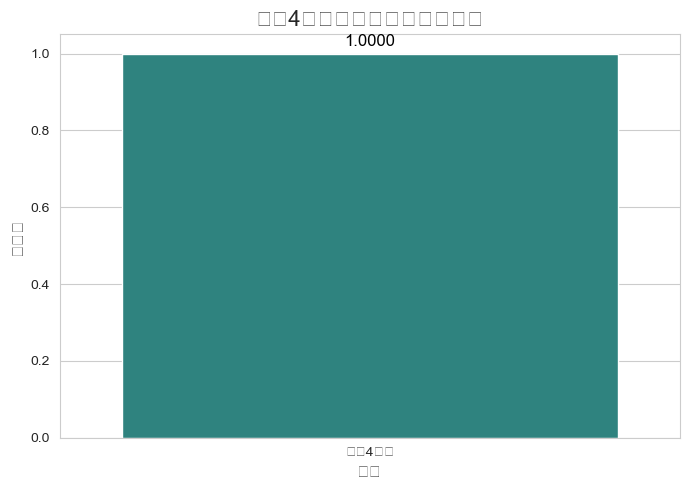

C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['问题4模型'], y=[f1_weighted_p4], palette='plasma')
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:66: UserWarning: Glyph 38382 (\N{CJK UNIFIED IDEOGRAPH-95EE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:66: UserWarning: Glyph 39064 (\N{CJK UNIFIED IDEOGRAPH-9898}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:66: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:66: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) Arial.
  plt.tight_layout()

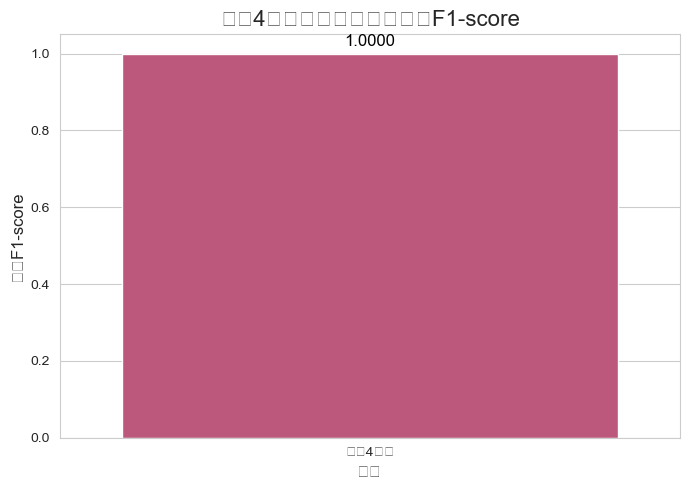

D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) Arial.
  fig.canvas.draw()
D:\conda\envs\motherc\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 33391 (\N{CJK UNIFIED IDEOGRAPH-826F}) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:81: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\俊宇\AppData\Local\Temp\ipykernel_24340\1694936412.py:81: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) Arial.
  plt.tig

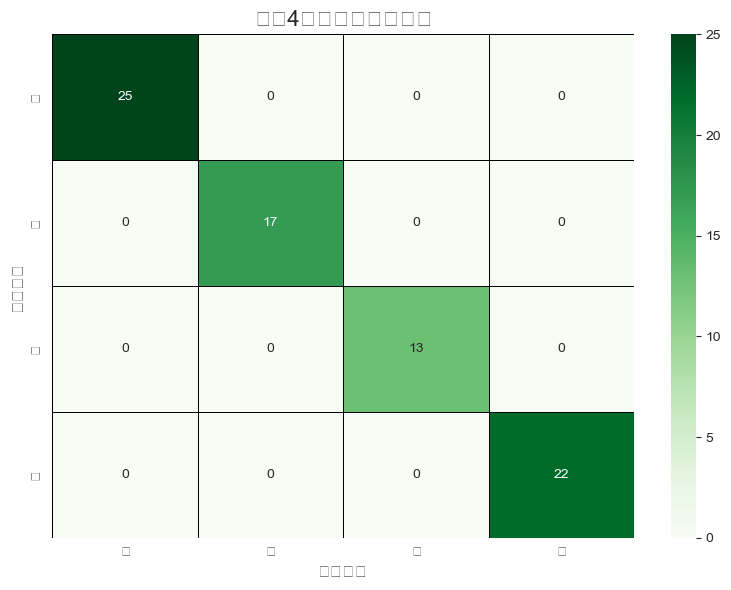

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 设置 Matplotlib 和 Seaborn 的样式，让图表更美观
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
sns.set_style("whitegrid") # 设置Seaborn风格

print("--- 问题4：模型评估可视化 ---")

# --- 1. 获取模型评估数据 ---
# 假设 y_test_split_P4 和 y_pred_best_P4 变量已从上一步运行中获取
# 它们分别是问题4模型在测试集上的真实标签和预测标签

# 如果您是分段运行，请确保这些变量在当前环境中是可用的。
# 示例：
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# import os
#
# # 假设df, df_with_sleep_data, X_train_P4, y_train_P4, numerical_features_P4, categorical_features_P4 都已定义
# # 并且 best_model_P4 也已训练并获取
#
# # 为了确保代码独立运行，这里模拟一下这些变量的获取，但在实际Jupyter环境中，它们应已存在
# # (此处省略数据加载和模型训练过程，假设y_test_split_P4和y_pred_best_P4已在内存中)
# # 例如，如果您从头运行，需要包含问题4的完整代码直到生成y_pred_best_P4
# # y_test_split_P4, y_pred_best_P4 = ... (从之前的运行中获取)


# 计算准确率和加权F1-score
accuracy_p4 = accuracy_score(y_test_split_P4, y_pred_best_P4)
f1_weighted_p4 = float(classification_report(y_test_split_P4, y_pred_best_P4, output_dict=True)['weighted avg']['f1-score'])

print(f"问题4模型准确率: {accuracy_p4:.4f}")
print(f"问题4模型加权F1-score: {f1_weighted_p4:.4f}")
print("-" * 60)

# --- 2. 绘制准确率图 ---
plt.figure(figsize=(7, 5))
sns.barplot(x=['问题4模型'], y=[accuracy_p4], palette='viridis')
plt.title('问题4模型在测试集上的准确率', fontsize=16)
plt.xlabel('模型', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.ylim(0, 1.05) # 准确率范围在0到1之间，略微超出以便显示标签
plt.text(0, accuracy_p4 + 0.02, f"{accuracy_p4:.4f}", color='black', ha="center", fontsize=12)
plt.tight_layout()
plt.show()

# --- 3. 绘制加权F1-score图 ---
plt.figure(figsize=(7, 5))
sns.barplot(x=['问题4模型'], y=[f1_weighted_p4], palette='plasma')
plt.title('问题4模型在测试集上的加权F1-score', fontsize=16)
plt.xlabel('模型', fontsize=12)
plt.ylabel('加权F1-score', fontsize=12)
plt.ylim(0, 1.05) # F1-score范围在0到1之间，略微超出以便显示标签
plt.text(0, f1_weighted_p4 + 0.02, f"{f1_weighted_p4:.4f}", color='black', ha="center", fontsize=12)
plt.tight_layout()
plt.show()

# --- 4. 绘制混淆矩阵热力图 ---
# 获取类别标签
class_labels = sorted(y_test_split_P4.unique()) # 确保标签顺序一致
conf_matrix = confusion_matrix(y_test_split_P4, y_pred_best_P4, labels=class_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=.5, linecolor='black') # 添加边框线
plt.title('问题4最佳模型混淆矩阵', fontsize=16)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.tight_layout()
plt.show()
